# Capítulo 3 - Modelo de séries temporais de despesa INSS (2000-2023) 
## Análise de Séries Temporais dos Gastos Previdenciários do INSS no Século XXI

**Universidade Federal Rural do Rio de Janeiro (UFRRJ)**  
**Instituto Multidisciplinar – Curso de Ciências Econômicas**  

**Autor:** Victor Flávio P. Dornelos  
**Orientadores:** Profª Dra. Elena Soihet e Profº Dr. Julio Cezar Russo

# 1- Biblioteca

In [45]:
# Instalando bibliotecas necessárias
#pip install -r requirements.txt

In [1]:
# Importando as principais bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# 2- Tratamento de dados

In [2]:
# Criando o DF
df= pd.read_csv('dados_entrada/despesa_inss_2023.csv', sep=';', encoding='latin1',header=1)

# Drop total
df.drop('Total',axis=1,inplace=True)

In [3]:
# Substituir vírgulas por pontos para converter strings para floats
df.iloc[:, 1:] = df.iloc[:, 1:].replace(',', '.', regex=True).astype(float)

# Transformar o DataFrame no formato longo (melt)
df_long = df.melt(id_vars=['Ano'], var_name='Mês', value_name='Valor')

# Mapeamento dos meses para formato numérico
month_mapping = {
    'Janeiro': '01',
    'Fevereiro': '02',
    'Março': '03',
    'Abril': '04',
    'Maio': '05',
    'Junho': '06',
    'Julho': '07',
    'Agosto': '08',
    'Setembro': '09',
    'Outubro': '10',
    'Novembro': '11',
    'Dezembro': '12'
}

# Mapear os meses e remover linhas inválidas
df_long['Mês'] = df_long['Mês'].map(month_mapping)
df_long = df_long[df_long['Mês'].notna()]

# Criar a coluna 'Data' no formato MM/YYYY
df_long['Data'] = pd.to_datetime(df_long['Ano'].astype(str) + '/' + df_long['Mês'], format='%Y/%m', errors='coerce')

# Remover linhas inválidas onde 'Data' é NaT
df_long = df_long[df_long['Data'].notna()]

# Selecionar as colunas finais
df_final = df_long[['Data', 'Valor']]

In [4]:
# Organizar o DataFrame pela coluna 'Data' em ordem crescente
df_final = df_final.sort_values(by='Data')

# Resetar os índices para manter o DataFrame limpo (opcional)
df_final = df_final.reset_index(drop=True)

In [5]:
df = df_final

# Data vira index
df.set_index('Data', inplace=True)
# Somente valor depois de data 1999-12-01
df = df[df.index >= '2000-01-01']

# Converter a coluna 'Valor' para float
df['Valor'] = df['Valor'].astype(float)

# Arredondar para milhao e duas casas decimais
df['Valor'] = df['Valor'] / 1000000
df['Valor'] = df['Valor'].round(2)

df3 = df.copy()
df5 = df.copy()
df6 = df.copy()
df_sarima = df.copy()
df_fb = df.copy()

/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_3617/711311016.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Valor'] = df['Valor'].astype(float)
/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_3617/711311016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Valor'] = df['Valor'] / 1000000
/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_3617/711311016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [6]:
df_sarima.to_excel('dados_saida/df_sarima.xlsx')

# 3 - Análise de dados da serie temporal

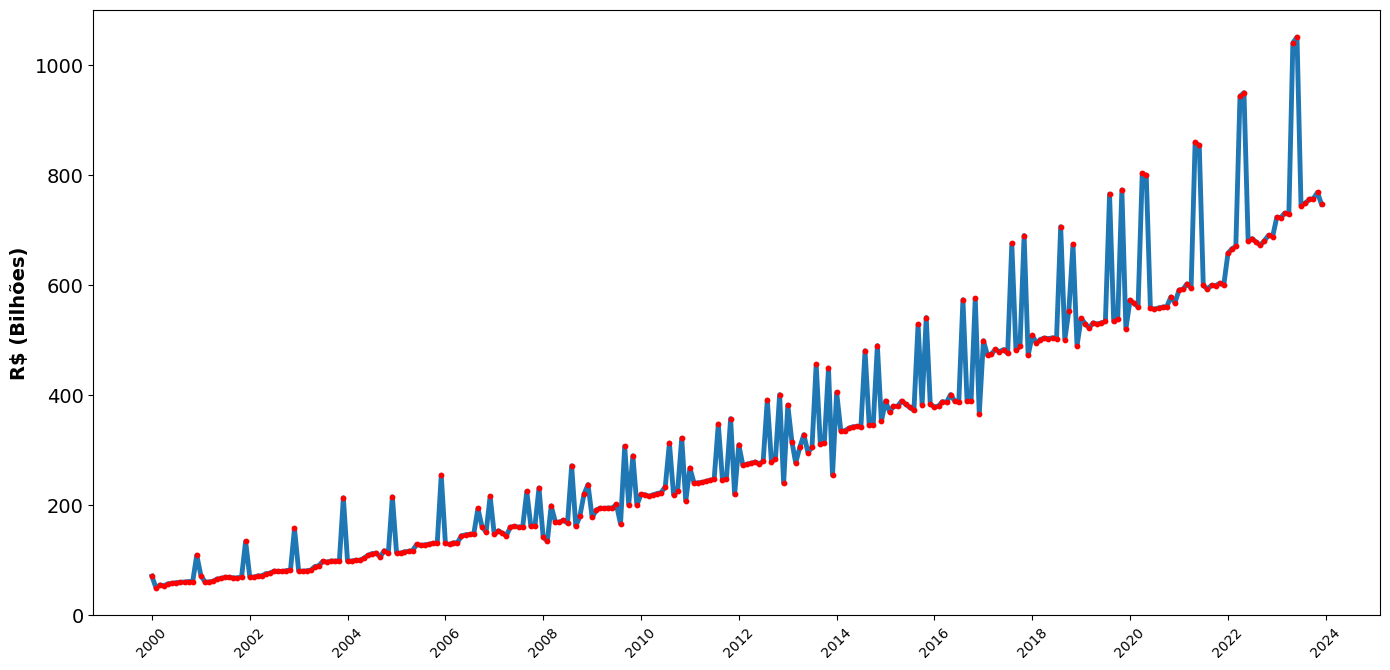

In [11]:
plt.figure(figsize=(14, 7))

# Dividindo os valores por 1e9 para transformar em bilhões
sns.lineplot(x=df.index, y=df['Valor'] / 100, linewidth=3.5)
plt.scatter(df.index, df['Valor'] / 100, color='red', s=10, zorder=5)

# Configurando o formato e os ticks do eixo X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.xticks(rotation=45)
plt.yticks(fontsize=14)

# Configurações adicionais
plt.ylabel('R$ (Bilhões)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.xlabel('')
plt.grid(False)
plt.show()


/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_3617/677590547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ano'] = df.index.year


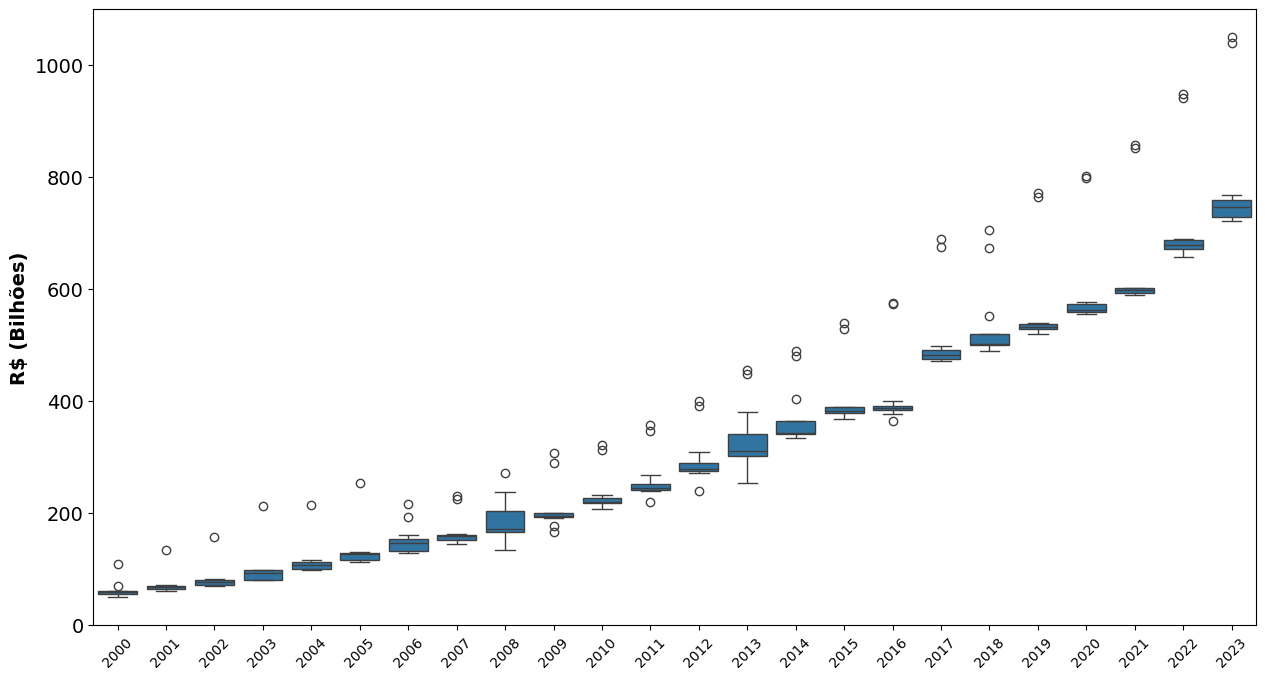

In [16]:
# Criando gráfico Box Plot anual
df['Ano'] = df.index.year

plt.figure(figsize=(15, 8))

# Dividindo por 100 apenas para este gráfico
sns.boxplot(x='Ano', y='Valor', data=df.assign(Valor=df['Valor'] / 100))

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('')
plt.ylabel('R$ (Bilhões)', fontsize=14, fontweight='bold')
plt.yticks(fontsize=14)  # Aumentando os yticks
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

In [18]:
# Analisando efeito sazonal por meio do Box Plot
meses = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
         7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_3617/768459883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mês'] = df.index.month.map(meses)


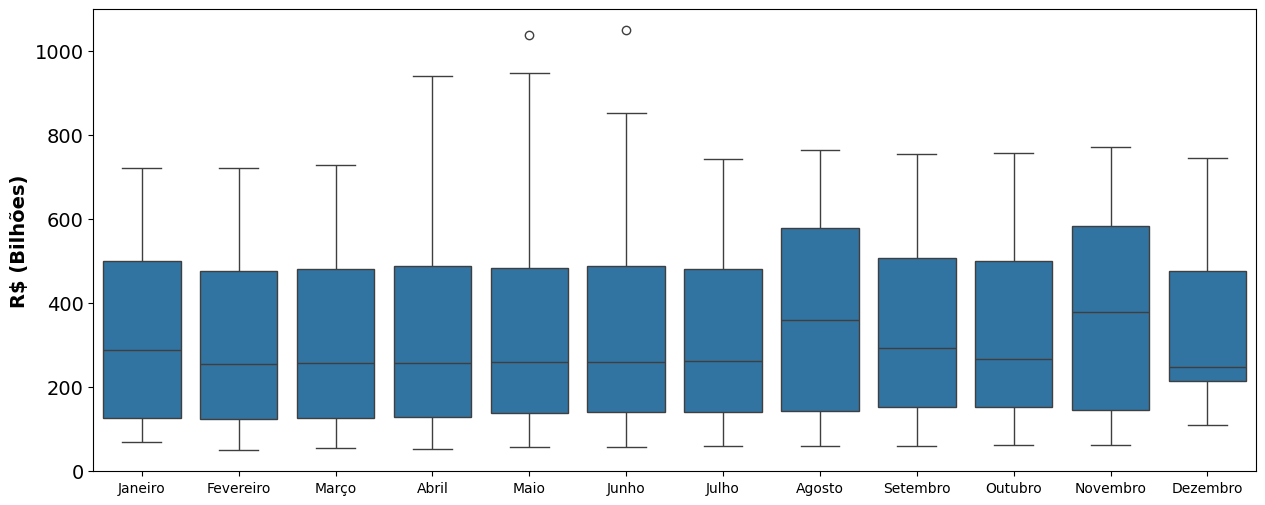

In [20]:

df['Mês'] = df.index.month.map(meses)

plt.figure(figsize=(15, 6))

# Dividindo os valores por 100 apenas neste gráfico
sns.boxplot(x='Mês', y=df['Valor'] / 100, data=df)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('')
plt.ylabel('R$ (Bilhões)', fontsize=14, fontweight='bold')
plt.yticks(fontsize=14)  # Aumentando os valores do eixo Y
plt.grid(False)
plt.show()

In [21]:
# Decompondo a série para novas análises
serie_temporal = df['Valor']
decomposicao = sm.tsa.seasonal_decompose(serie_temporal, model='additive')

<Figure size 2000x1000 with 0 Axes>

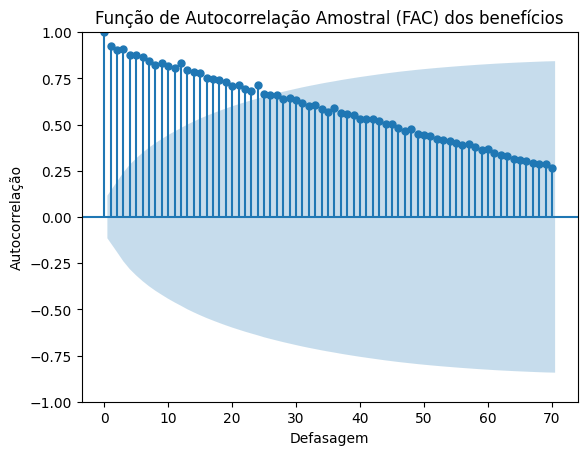

In [22]:
# Criando gráfico de FAC
plt.figure(figsize=(20, 10))
plot_acf(serie_temporal, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

<Figure size 2000x1000 with 0 Axes>

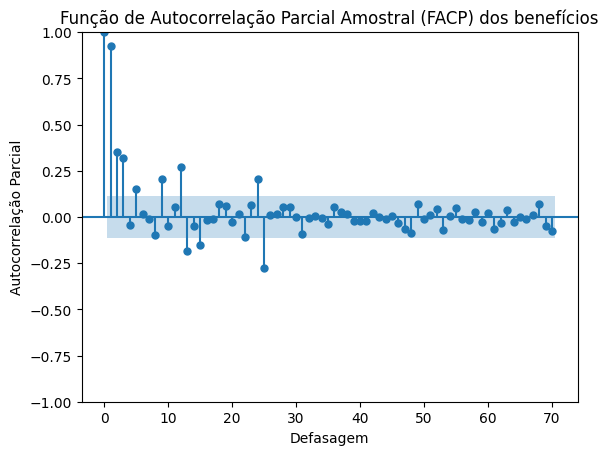

In [23]:
# Criando gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(serie_temporal, lags=70)  
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.show()

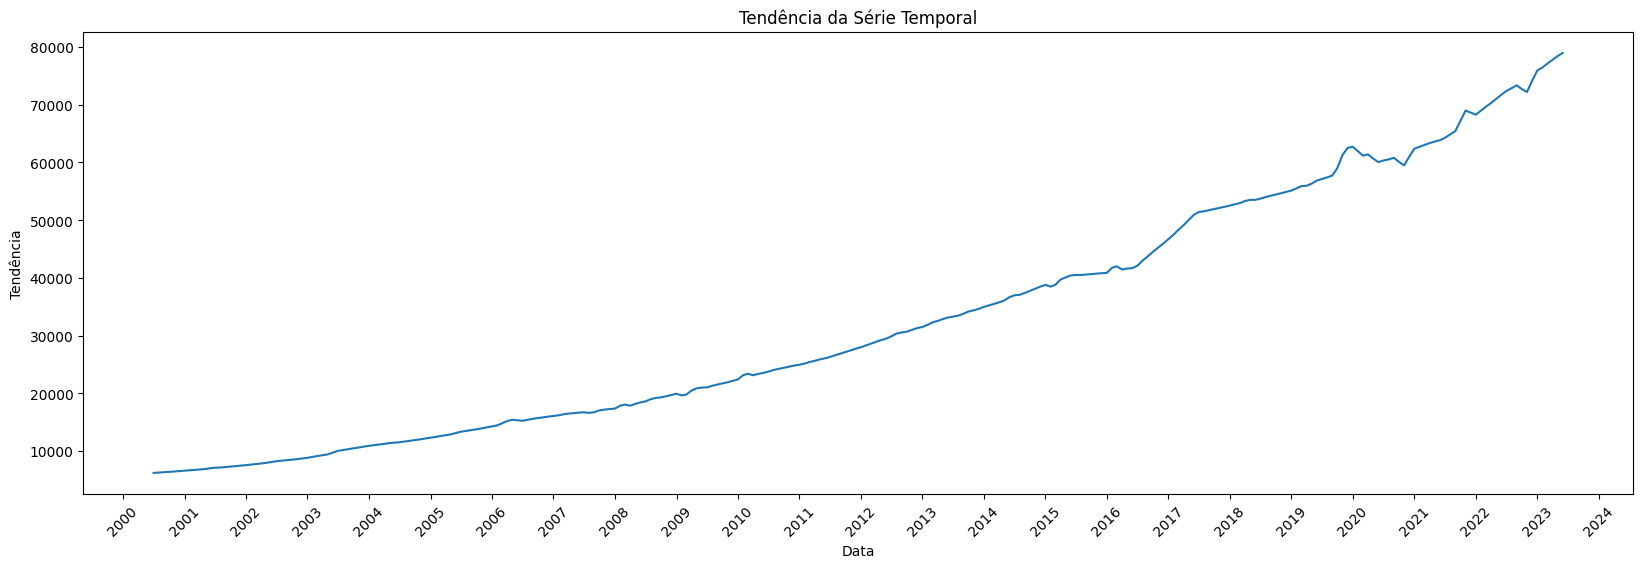

In [24]:
# Gráfico de tendência
plt.figure(figsize=(20, 6))
sns.lineplot(data=decomposicao.trend)
plt.title('Tendência da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.ylabel('Tendência')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

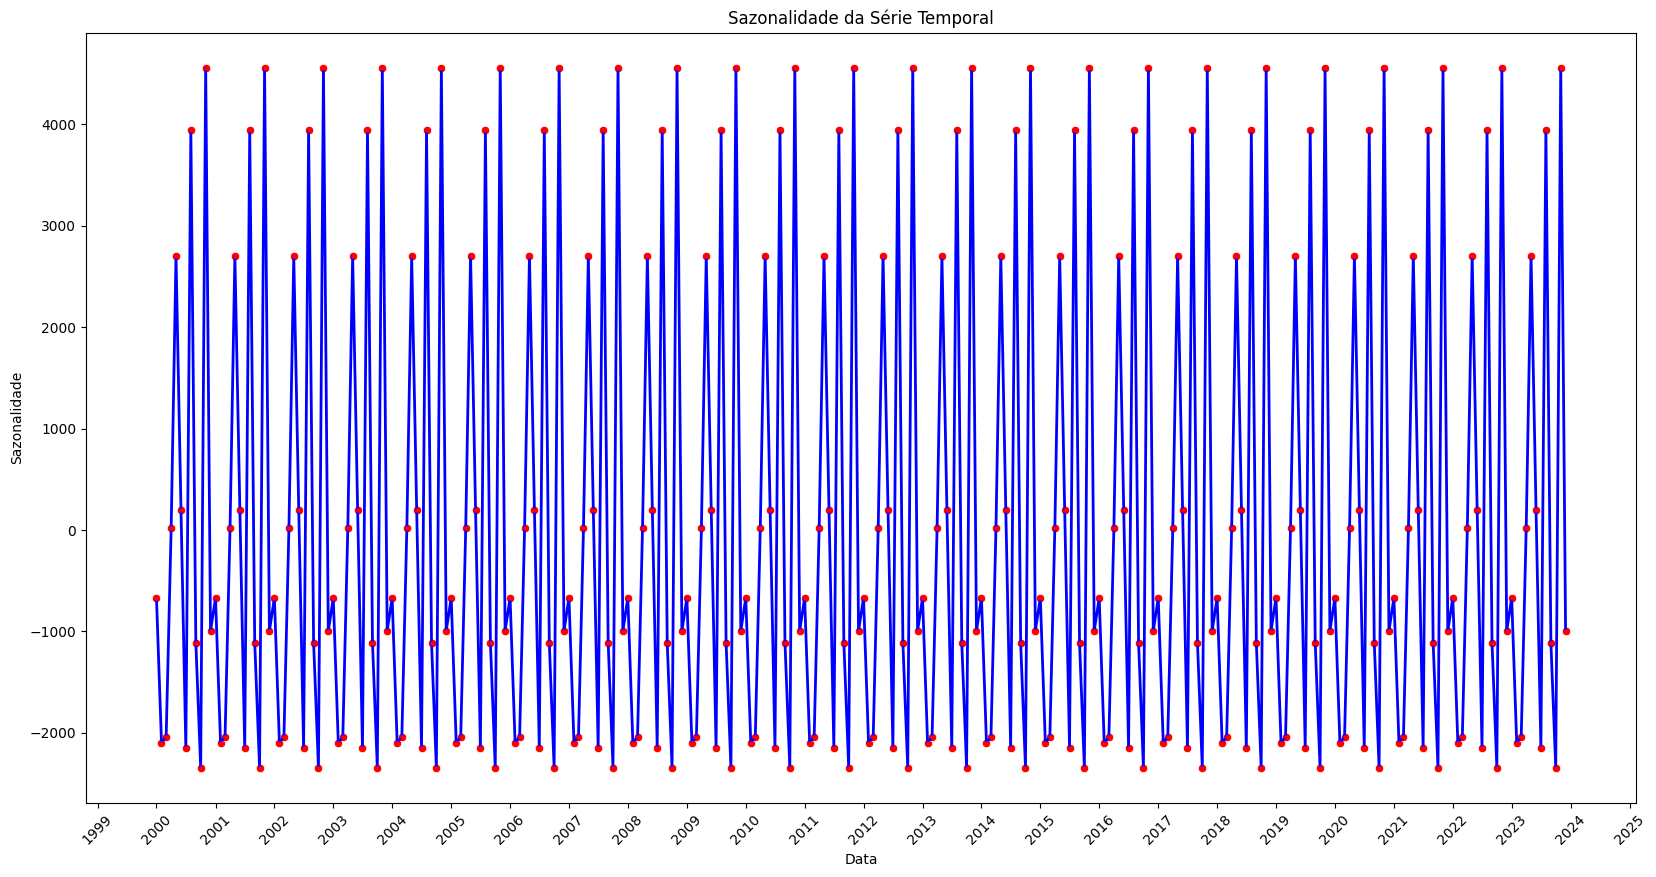

In [25]:
# Gráfico de Sazonalidade
plt.figure(figsize=(20, 10))
sns.lineplot(data=decomposicao.seasonal, color='blue', linewidth=2)
sns.scatterplot(data=decomposicao.seasonal, color='red', marker='o')
plt.scatter(decomposicao.seasonal.index, decomposicao.seasonal.values, color='red', s=5, zorder=5)
plt.title('Sazonalidade da Série Temporal')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Sazonalidade')
plt.xticks(rotation=45)
plt.show()

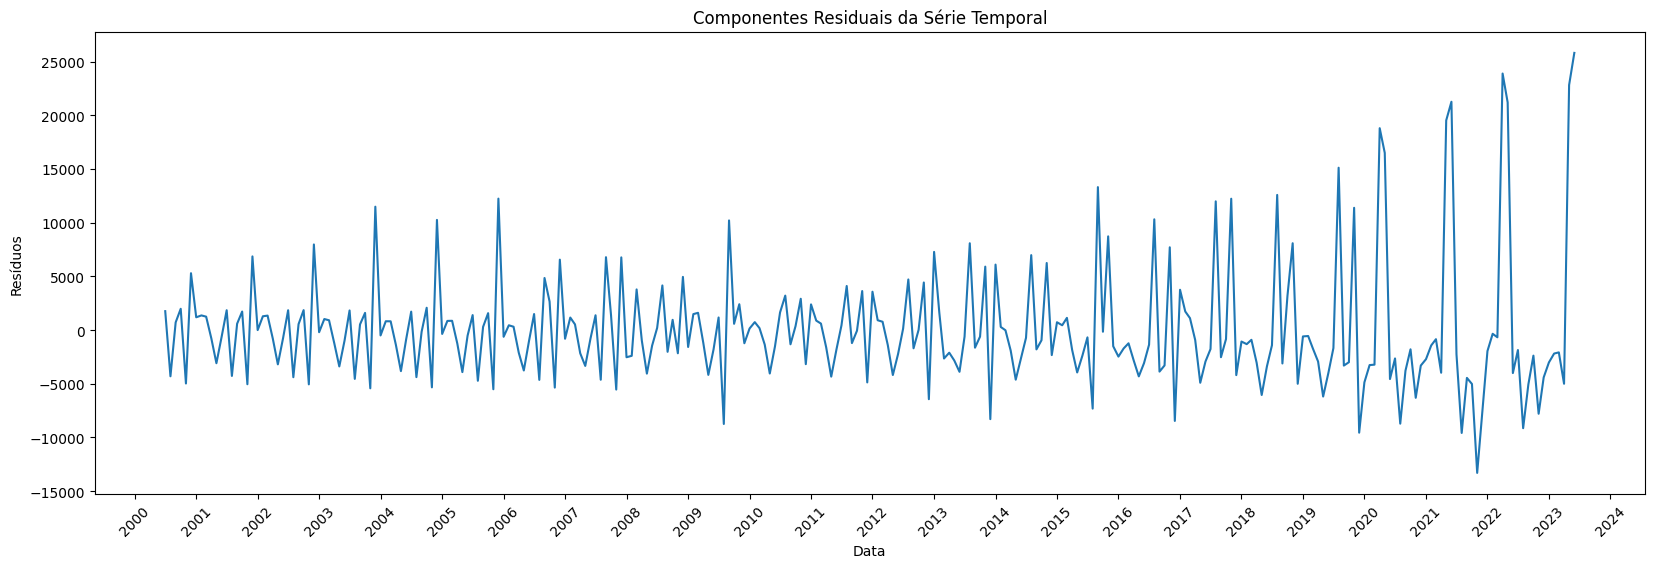

In [26]:
# Gráfico de ruído
plt.figure(figsize=(20,6))
sns.lineplot(data=decomposicao.resid)
plt.title('Componentes Residuais da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Resíduos')
plt.xticks(rotation=45)
plt.show()


In [27]:
# Realizando teste de hipótese de estacionalidade
result= adfuller(df3)
print(f'P-valor {result[1]}')

P-valor 1.0


In [28]:
# Realizando uma diferenciação na série para corrigir a estacionalidade
df3= df3.diff()
df3=df3.dropna()
result2= adfuller(df3)
print(f'P-valor {result2[1]}')

P-valor 1.589928192609075e-12


<Figure size 2000x600 with 0 Axes>

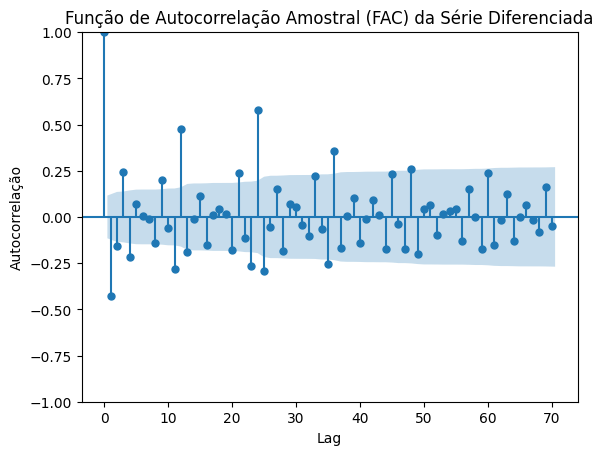

In [29]:
# Novo gráfico FAC
plt.figure(figsize=(20, 6))
plot_acf(df3, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) da Série Diferenciada')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

In [30]:
# Garantindo que a série está em formato correto
N = len(df3)  # Número de observações na série

# Cálculo da função de autocorrelação (FAC) até lag 11
fac_values = sm.tsa.acf(df3, nlags=11)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  # Para 95% de confiança
threshold = z_score / np.sqrt(N)  # Margem de erro de 5%

# Criar uma lista apenas com os lags significativos
lags_significativos = [lag for lag, val in enumerate(fac_values) if abs(val) > threshold]

# Exibir a lista de lags significativos
print("Lags com dependência significativa:", lags_significativos)




Lags com dependência significativa: [0, 1, 2, 3, 4, 8, 9, 11]


In [31]:
# fac menor igual a 4
fac = lags_significativos 

<Figure size 2000x1000 with 0 Axes>

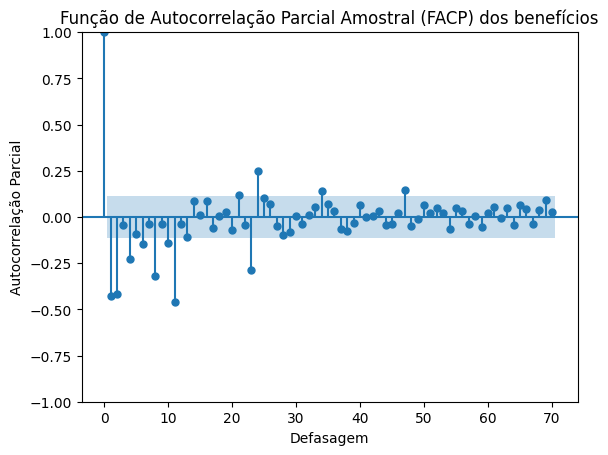

In [32]:
# Novo gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(df3, lags=70)  # Define o número de lags para calcular a FACP
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.grid(False)
plt.show()

In [33]:
# Garantindo que a série está em formato correto
N = len(df3)  # Número de observações na série

# Cálculo da função de autocorrelação parcial (FACP) até lag 11
facp_values = sm.tsa.pacf(df3, nlags=11)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  # Para 95% de confiança
threshold = z_score / np.sqrt(N)  # Margem de erro de 5%

# Criar uma lista apenas com os lags significativos
lags_significativos_facp = [lag for lag, val in enumerate(facp_values) if abs(val) > threshold]

# Exibir a lista de lags significativos na FACP
print("Lags com dependência significativa na FACP:", lags_significativos_facp)

Lags com dependência significativa na FACP: [0, 1, 2, 4, 6, 8, 10, 11]


In [34]:
facp = lags_significativos_facp

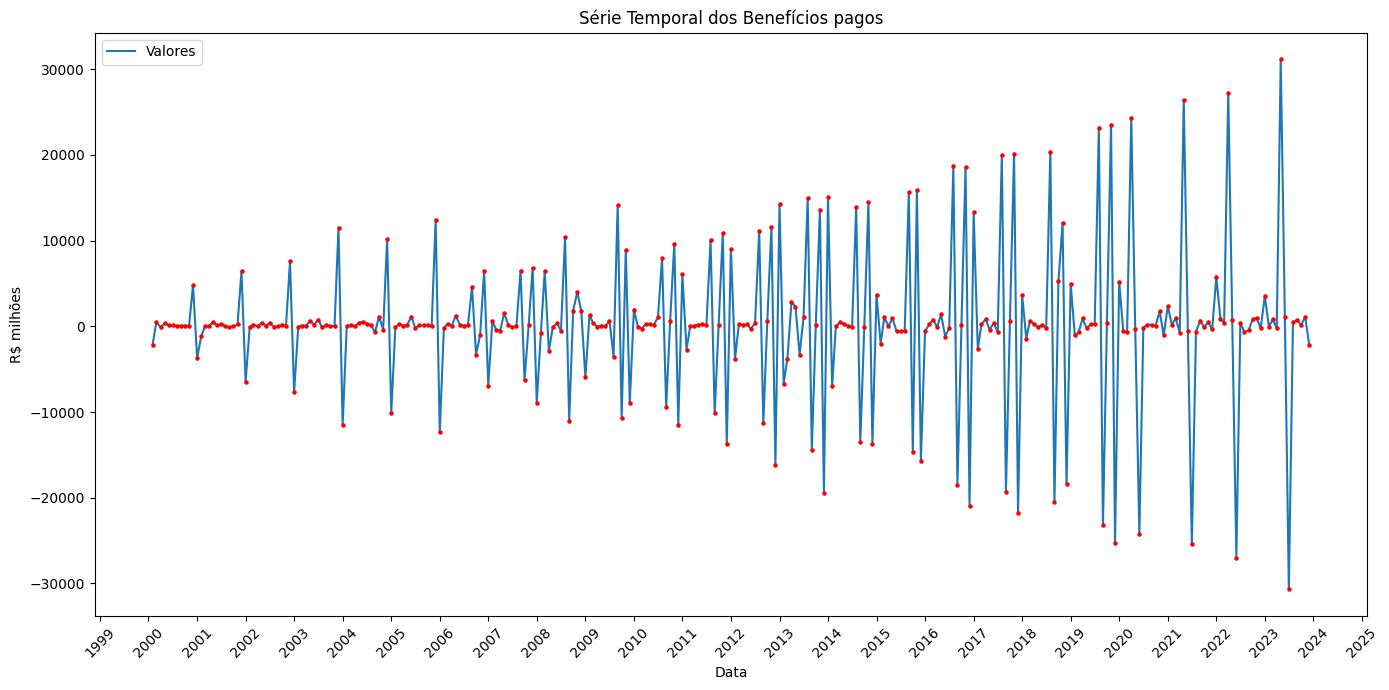

In [35]:
# Novo gráfico de série temporal
plt.figure(figsize=(14, 7))
sns.lineplot(x=df3.index, y=df3['Valor'], label='Valores')
plt.scatter(df3.index, df3['Valor'], color='red', s=5, zorder=5)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)


plt.title('Série Temporal dos Benefícios pagos')
plt.xlabel('Data')
plt.ylabel('R$ milhões')

# Mostrar o gráfico
plt.tight_layout()
plt.grid(False)
plt.show()


In [36]:
s = 12  
N = len(df3)  # Número de observações na série

# Diferenciar sazonalmente a série (para remover efeitos sazonais)
df3_s_diff = df3.diff(s).dropna()

# Calcular FAC e FACP até 3 ciclos sazonais (36 lags)
fac_values = sm.tsa.acf(df3_s_diff, nlags=s*3)
facp_values = sm.tsa.pacf(df3_s_diff, nlags=s*3)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  
threshold = z_score / np.sqrt(N)  

# Criar listas com os lags significativos
lags_significativos_fac = [lag for lag, val in enumerate(fac_values) if abs(val) > threshold]
lags_significativos_facp = [lag for lag, val in enumerate(facp_values) if abs(val) > threshold]

# Exibir os resultados
print("Lags significativos na FAC (Q):", lags_significativos_fac)
print("Lags significativos na FACP (P):", lags_significativos_facp)

Lags significativos na FAC (Q): [0, 1, 2, 3, 4, 5, 8, 11, 12, 13, 14, 15, 17, 20, 24, 25, 29, 31, 32]
Lags significativos na FACP (P): [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [37]:
# fac ate  5
fac_s = lags_significativos_fac 

# facp ate 4
facp_s = lags_significativos_facp 

# 4- MODELO SARIMA

In [38]:
# Importando bibliotecas para estimar os erros
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [39]:
# Criando uma função para um parâmetro de erro
def mean_percentage_error(Y,y):
    mpe = np.mean((Y - y )/ Y) * 100
    return mpe

In [40]:
# Função para criar DF com valores dos erros
def teste_erro(serie,previsao):

    MAD = mean_absolute_error(y_true=serie,y_pred=previsao)
    MAPE = mean_absolute_percentage_error(y_true=serie,y_pred=previsao)
    MSD = mean_squared_error(y_true=serie,y_pred=previsao)
    MPE = mean_percentage_error(serie,previsao)

    erros = pd.DataFrame({
        'Metric': ['MAD', 'MAPE', 'MSD', 'MPE'],
        'Value': [MAD, MAPE, MSD, MPE]
    })
    
    return erros

In [41]:
# print fac e facp 
print(fac)
print(facp)
print(fac_s)
print(facp_s)

[0, 1, 2, 3, 4, 8, 9, 11]
[0, 1, 2, 4, 6, 8, 10, 11]
[0, 1, 2, 3, 4, 5, 8, 11, 12, 13, 14, 15, 17, 20, 24, 25, 29, 31, 32]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [42]:
fac = [x for x in fac if x >0 and x < 5]
facp = [x for x in facp if x > 0 and x < 6]
fac_s = [x for x in fac_s if x > 0 and x <7]
facp_s = [x for x in facp_s if x > 0 and x < 5]



In [43]:
""" 
import modelo_sarima  # Importa o módulo

# Definir intervalos personalizados
p_values = fac 
d_values = [1]  # Manter d fixo
q_values = facp  
P_values = fac_s  
D_values = [1] 
Q_values = facp_s 
s = 12  # Sazonalidade mensal

# Rodar a função com os intervalos escolhidos
modelo_sarima.run_sarima_grid_search(
    file_path="dados_saida/df_sarima.xlsx",
    output_file="resultado/resultados_sarima_teste_2023.xlsx",
    p_values=p_values,
    d_values=d_values,
    q_values=q_values,
    P_values=P_values,
    D_values=D_values,
    Q_values=Q_values,
    s=s
)
 """


' \nimport modelo_sarima  # Importa o módulo\n\n# Definir intervalos personalizados\np_values = fac \nd_values = [1]  # Manter d fixo\nq_values = facp  \nP_values = fac_s  \nD_values = [1] \nQ_values = facp_s \ns = 12  # Sazonalidade mensal\n\n# Rodar a função com os intervalos escolhidos\nmodelo_sarima.run_sarima_grid_search(\n    file_path="dados_saida/df_sarima.xlsx",\n    output_file="resultado/resultados_sarima_teste_2023.xlsx",\n    p_values=p_values,\n    d_values=d_values,\n    q_values=q_values,\n    P_values=P_values,\n    D_values=D_values,\n    Q_values=Q_values,\n    s=s\n)\n '

In [44]:
result_df = pd.read_excel('resultado/resultados_sarima_teste_2023.xlsx')

In [46]:
# Carregar o DataFrame fixo (suponha que df_sarima já esteja carregado no ambiente)
df_sarima.index = pd.to_datetime(df_sarima.index)  # Garantir que o índice seja datetime

def rodar_sarimax(df_params, index):
    """
    Roda o modelo SARIMAX com base nos parâmetros de uma linha específica do DataFrame `df_params`.

    Parâmetros:
    df_params (pd.DataFrame): DataFrame contendo os parâmetros dos modelos.
    index (int): Índice da linha no DataFrame para extrair os parâmetros.

    Retorna:
    Modelo ajustado SARIMAX.
    """
    row = df_params.iloc[index]
    
    # Extraindo os parâmetros da linha
    p, d, q = int(row["p"]), int(row["d"]), int(row["q"])
    P, D, Q = int(row["P"]), int(row["D"]), int(row["Q"])
    
    # Definir as ordens
    order = (p, d, q)
    seasonal_order = (P, D, Q, 12)  # Mantendo sazonalidade fixa em 12 meses
    
    # Ajustando o modelo SARIMAX sempre com df_sarima
    model = sm.tsa.statespace.SARIMAX(df_sarima["Valor"], 
                                      order=order, 
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit()
    
    return results



# 4-  Análise de resultados

In [47]:
result_df.index.freq = 'MS' 
resultado_modelo = rodar_sarimax(result_df, 0)
resultado_modelo.summary()

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Valor   No. Observations:                  288
Model:             SARIMAX(4, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -2115.593
Date:                            Sat, 19 Jul 2025   AIC                           4259.186
Time:                                    10:27:48   BIC                           4306.112
Sample:                                01-01-2000   HQIC                          4278.155
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6401      0.300     -2.132      0.033      -1.228      -0.052
ar.L2          0.0629      0.151      0.415      0.678      -0.234       0.360
ar.L3          0.0402      0.128      0.315      0.753      -0.210       0.290
ar.L4         -0.0223      0.128     -0.174      0.862      -0.273       0.228
ma.L1         -0.1298      0.292     -0.445      0.656      -0.701       0.442
ma.L2         -0.7906      0.271     -2.914      0.004      -1.322      -0.259
ar.S.L12      -0.6801      0.254     -2.677      0.007      -1.178      -0.182
ar.S.L24      -0.7750      0.296     -2.617      0.009      -1.355      -0.195
ar.S.L36      -0.5590      0.204     -2.745      0.006      -0.958      -0.160
ar.S.L48      -0.3678      0.163     -2.252      0.024      -0.688      -0.048
ar.S.L60      -0.1960      0.184     -1.063      0.288      -0.557       0.165
ma.S.L12       0.0667      0.265      0.252      0.801      -0.453       0.586
ma.S.L24       0.8091      0.262      3.089      0.002       0.296       1.322
sigma2      3.939e+07    8.3e-09   4.75e+15      0.000    3.94e+07    3.94e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               184.10
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               3.82   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.69e+31. Standard errors may be unstable.
"""

In [48]:
resultado_modelo2 = rodar_sarimax(result_df, 1)
resultado_modelo2.summary()

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      Valor   No. Observations:                  288
Model:             SARIMAX(4, 1, 4)x(5, 1, [1, 2, 3], 12)   Log Likelihood               -2112.602
Date:                                    Sat, 19 Jul 2025   AIC                           4259.204
Time:                                            10:28:28   BIC                           4316.186
Sample:                                        01-01-2000   HQIC                          4282.238
                                             - 12-01-2023                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0851      0.881     -0.097      0.923      -1.811       1.641
ar.L2          0.4555      0.585      0.779      0.436      -0.690       1.601
ar.L3          0.1354      0.571      0.237      0.813      -0.984       1.254
ar.L4         -0.1415      0.152     -0.931      0.352      -0.439       0.156
ma.L1         -0.7036      0.897     -0.785      0.433      -2.461       1.054
ma.L2         -0.7648      1.006     -0.760      0.447      -2.737       1.208
ma.L3          0.3363      0.676      0.497      0.619      -0.989       1.662
ma.L4          0.1657      0.693      0.239      0.811      -1.192       1.524
ar.S.L12      -1.2791      0.442     -2.891      0.004      -2.146      -0.412
ar.S.L24      -1.2397      0.354     -3.505      0.000      -1.933      -0.546
ar.S.L36      -1.2012      0.474     -2.533      0.011      -2.131      -0.272
ar.S.L48      -0.7407      0.325     -2.278      0.023      -1.378      -0.103
ar.S.L60      -0.3455      0.128     -2.689      0.007      -0.597      -0.094
ma.S.L12       0.6550      0.466      1.406      0.160      -0.258       1.568
ma.S.L24       0.9103      0.202      4.516      0.000       0.515       1.305
ma.S.L36       0.6452      0.533      1.211      0.226      -0.399       1.690
sigma2      3.652e+07    2.8e-07   1.31e+14      0.000    3.65e+07    3.65e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               163.82
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.60   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.43e+29. Standard errors may be unstable.
"""

In [49]:
resultado_modelo3 = rodar_sarimax(result_df, 2)
resultado_modelo3.summary()

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Valor   No. Observations:                  288
Model:             SARIMAX(4, 1, 4)x(5, 1, [1, 2], 12)   Log Likelihood               -2113.931
Date:                                 Sat, 19 Jul 2025   AIC                           4259.862
Time:                                         10:28:49   BIC                           4313.492
Sample:                                     01-01-2000   HQIC                          4281.541
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2520      0.893     -0.282      0.778      -2.003       1.499
ar.L2          0.5826      0.667      0.873      0.382      -0.725       1.890
ar.L3          0.1992      0.725      0.275      0.784      -1.222       1.621
ar.L4         -0.1417      0.147     -0.964      0.335      -0.430       0.146
ma.L1         -0.5408      0.916     -0.590      0.555      -2.337       1.255
ma.L2         -0.9627      1.061     -0.907      0.364      -3.043       1.118
ma.L3          0.2776      0.714      0.389      0.697      -1.122       1.677
ma.L4          0.2660      0.823      0.323      0.747      -1.348       1.880
ar.S.L12      -1.0168      0.308     -3.299      0.001      -1.621      -0.413
ar.S.L24      -0.6018      0.414     -1.454      0.146      -1.413       0.210
ar.S.L36      -0.3491      0.210     -1.661      0.097      -0.761       0.063
ar.S.L48      -0.4383      0.184     -2.387      0.017      -0.798      -0.078
ar.S.L60      -0.4041      0.155     -2.604      0.009      -0.708      -0.100
ma.S.L12       0.3820      0.319      1.199      0.231      -0.243       1.007
ma.S.L24       0.3784      0.331      1.143      0.253      -0.271       1.027
sigma2      3.652e+07   1.66e-07    2.2e+14      0.000    3.65e+07    3.65e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               192.56
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               4.02   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+31. Standard errors may be unstable.
"""

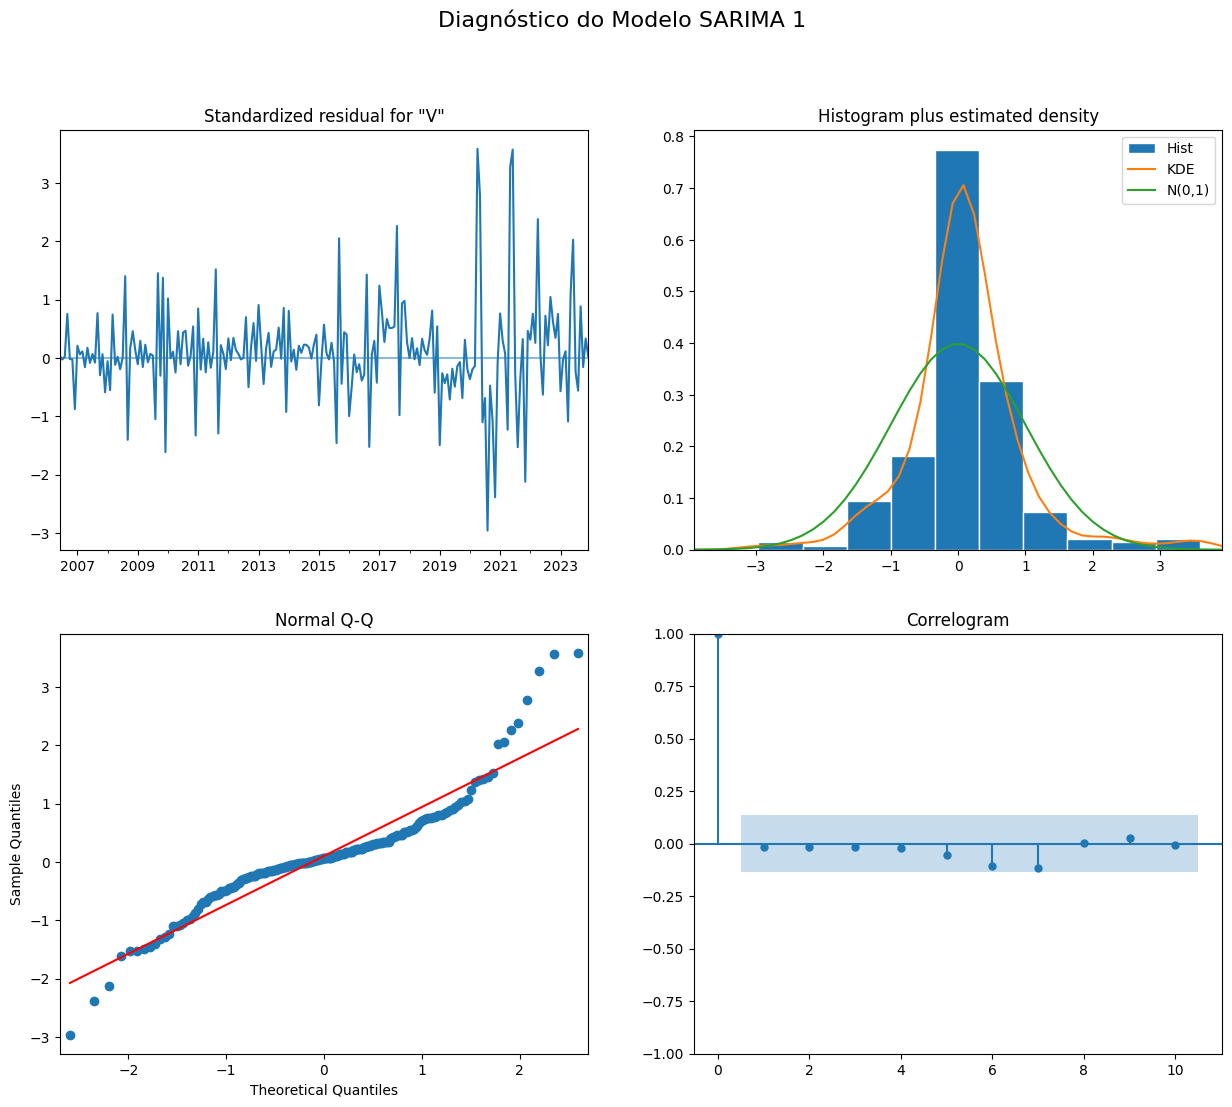

In [50]:
resultado_modelo.plot_diagnostics(figsize=(15, 12))
plt.grid(False)
plt.suptitle('Diagnóstico do Modelo SARIMA 1', fontsize=16)
plt.show()

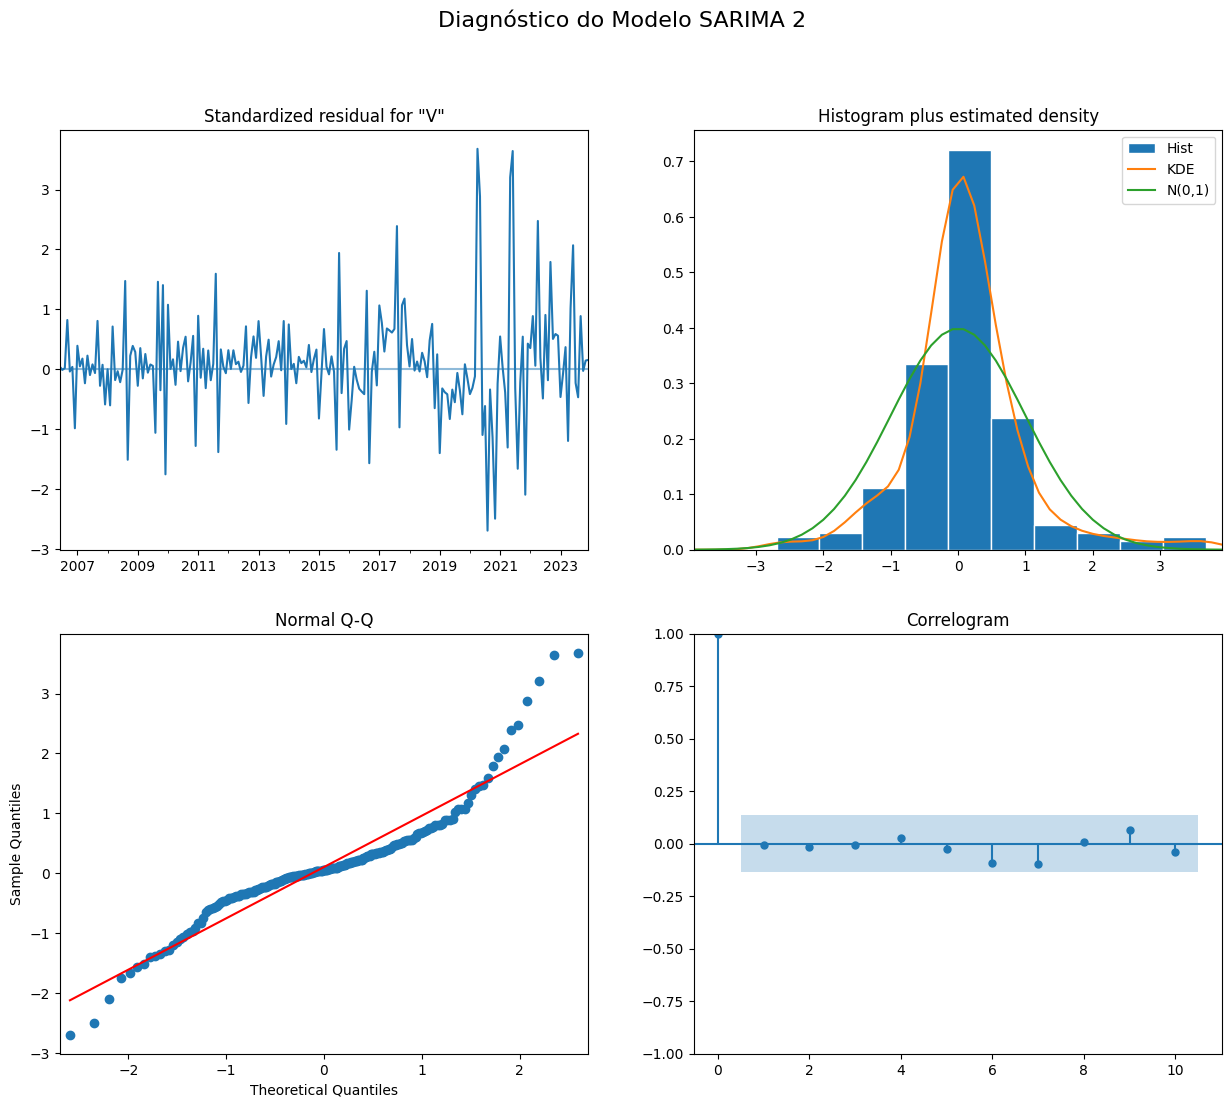

In [51]:
resultado_modelo2.plot_diagnostics(figsize=(15, 12))
plt.grid(False)
plt.suptitle('Diagnóstico do Modelo SARIMA 2', fontsize=16)
plt.show()

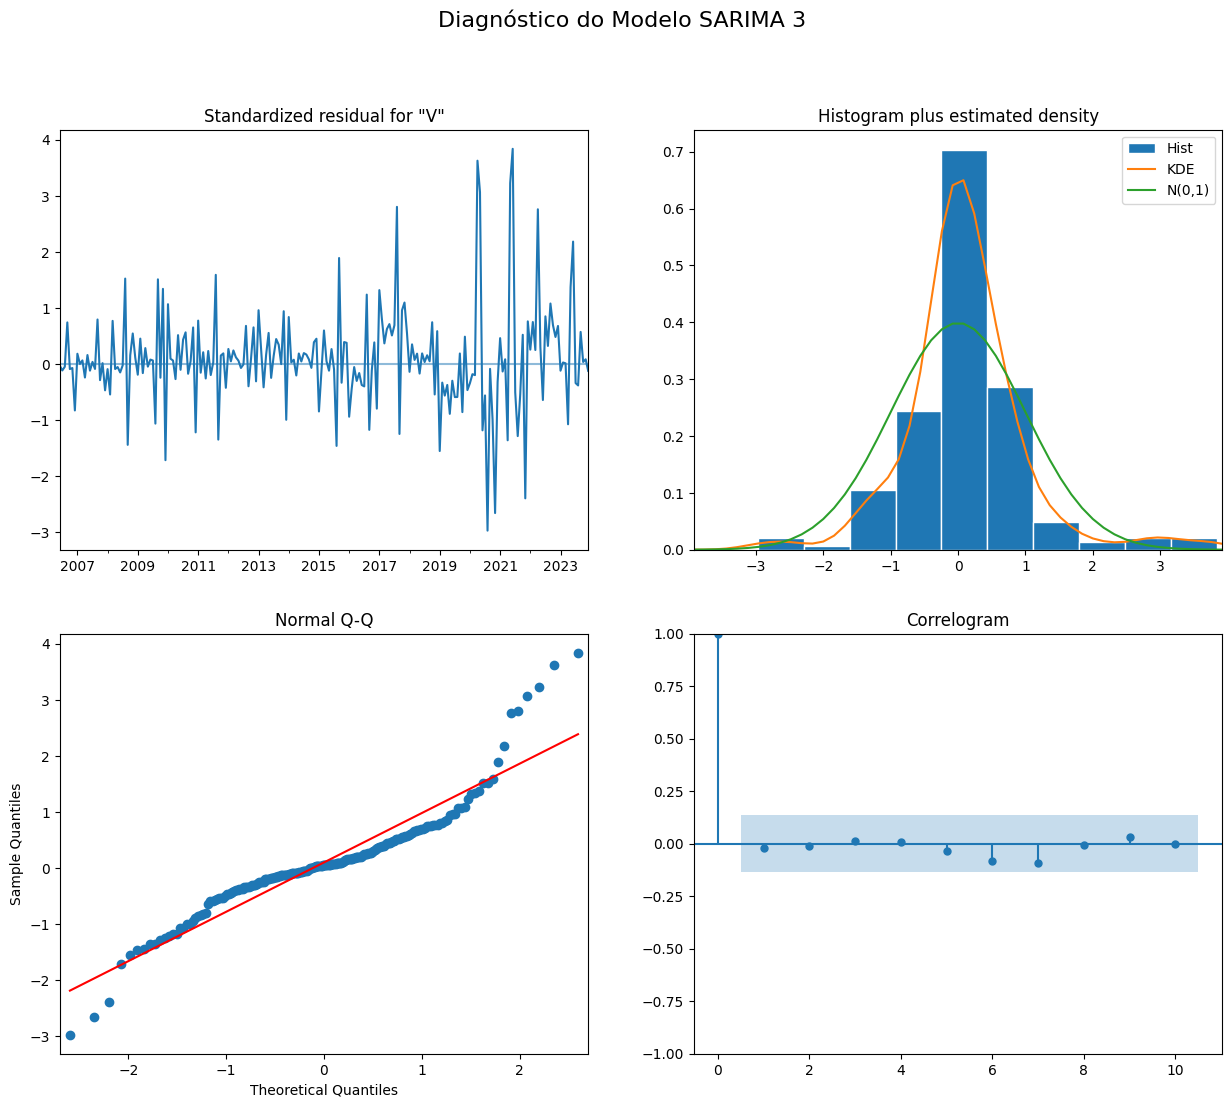

In [52]:
resultado_modelo3.plot_diagnostics(figsize=(15, 12))
plt.grid(False)
plt.suptitle('Diagnóstico do Modelo SARIMA 3', fontsize=16)
plt.show()

In [53]:
def calcular_metricas_e_testes(y_true, fitted, residuos):
    mad = mean_absolute_error(y_true, fitted)
    mape = mean_absolute_percentage_error(y_true, fitted)
    msd = mean_squared_error(y_true, fitted)
    mpe = ((y_true - fitted) / y_true).mean() * 100

    shapiro_test = shapiro(residuos)
    arch_test = het_arch(residuos)

    return {
        'MAD': mad,
        'MAPE': mape,
        'MSD': msd,
        'MPE': mpe,
        'Shapiro-Wilk (stat)': shapiro_test.statistic,
        'Shapiro-Wilk (p)': shapiro_test.pvalue,
        'ARCH (LM stat)': arch_test[0],
        'ARCH (p-value)': arch_test[1]
    }

# Lista para armazenar resultados
resultados = []

for nome, modelo in [
    ('SARIMA 1', resultado_modelo),
    ('SARIMA 2', resultado_modelo2),
    ('SARIMA 3', resultado_modelo3)
]:
    fitted = modelo.fittedvalues
    residuos = modelo.resid
    metricas_testes = calcular_metricas_e_testes(df_sarima['Valor'], fitted, residuos)
    metricas_testes['Modelo'] = nome
    resultados.append(metricas_testes)

# Montando o DataFrame final
df_final = pd.DataFrame(resultados).set_index('Modelo')


In [54]:
df_final.to_excel('resultado/metricas_modelos_sarima.xlsx')

# 5- Previsão

In [55]:
df_sarima['fitted'] = resultado_modelo.fittedvalues

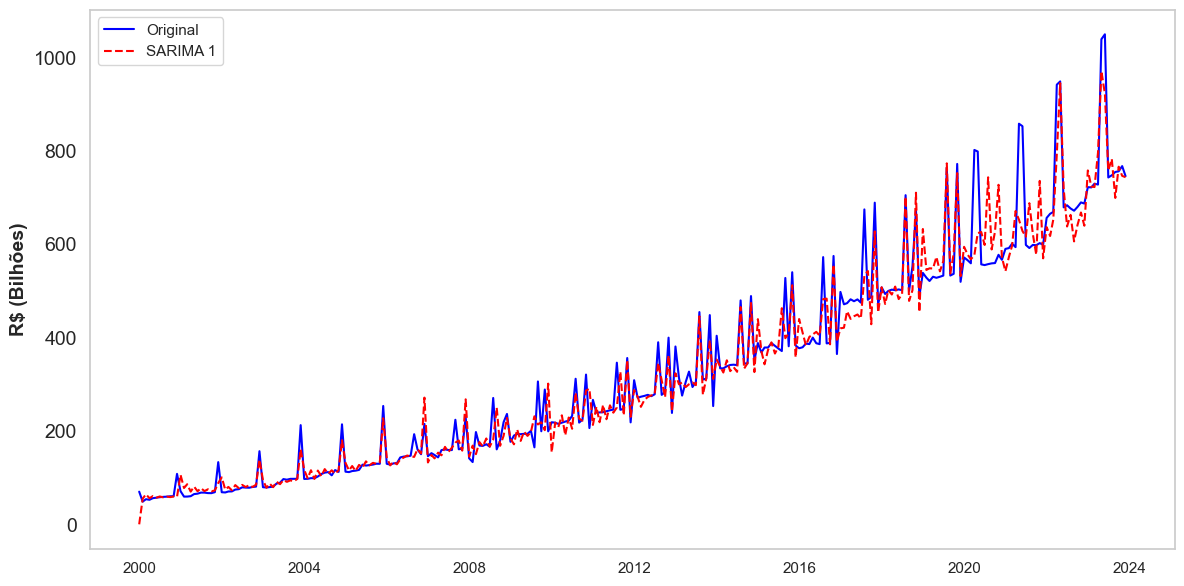

In [59]:
sns.set_theme(style="whitegrid")

# Plotando a série original e os valores ajustados pelo modelo (em bilhões)
plt.figure(figsize=(14, 7))
plt.tight_layout()

sns.lineplot(data=df_sarima, x=df_sarima.index, y=df_sarima['Valor'] / 100, label='Original', color='blue')
sns.lineplot(data=df_sarima, x=df_sarima.index, y=df_sarima['fitted'] / 100, label='SARIMA 1', color='red', linestyle='--')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('')
plt.yticks(fontsize=14)
plt.ylabel('R$ (Bilhões)', fontsize=14, fontweight='bold')
plt.grid(False)
plt.legend()
plt.show()

In [60]:
# Criando a figura
fig = go.Figure()

# Adicionando a série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Adicionando os valores ajustados pelo modelo SARIMA
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['fitted'],
    mode='lines',
    name='SARIMA Fitted',
    line=dict(color='red', dash='dash')
))

# Configurando o layout
fig.update_layout(
    title='Comparação entre a Série Original e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    yaxis=dict(tickformat=',d'),  # Formata os valores inteiros no eixo Y
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico interativo
fig.show()

In [97]:

pio.renderers.default = 'browser'  # Faz com que o gráfico abra no navegador
fig.show()

In [61]:


# Configurando para exibir no VS Code e no navegador
pio.renderers.default = "vscode"  # Para exibição no VS Code
# pio.renderers.default = "browser"  # Se quiser apenas no navegador

# Calculando a diferença entre a série real e o modelo ajustado
df_sarima['erro'] = df_sarima['Valor'] - df_sarima['fitted']

# Criando a figura
fig = go.Figure()

# Adicionando a linha fixa no Y = 0
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=[0] * len(df_sarima),  # Linha fixa no zero
    mode='lines',
    name='Linha Base (Y=0)',
    line=dict(color='black', dash='dash')
))

# Adicionando a série de erros (diferença entre real e ajustado)
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['erro'],
    mode='lines',
    name='Erro (Real - Modelo)',
    line=dict(color='red')
))

# Configurando o layout
fig.update_layout(
    title='Erro entre a Série Real e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='Erro (R$ mil)',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()

# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()

In [62]:
# Criando as previsões
forecast_periods = 12
forecast = resultado_modelo.forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=df_sarima.index[-1], periods=forecast_periods+1, freq='M')[1:]
forecast_values = forecast.values


/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_3617/2341208125.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [63]:
# Fazendo intervalo de confiança
ci = 1.96 * np.std(forecast_values)
lower_bound = forecast_values - ci
upper_bound = forecast_values + ci

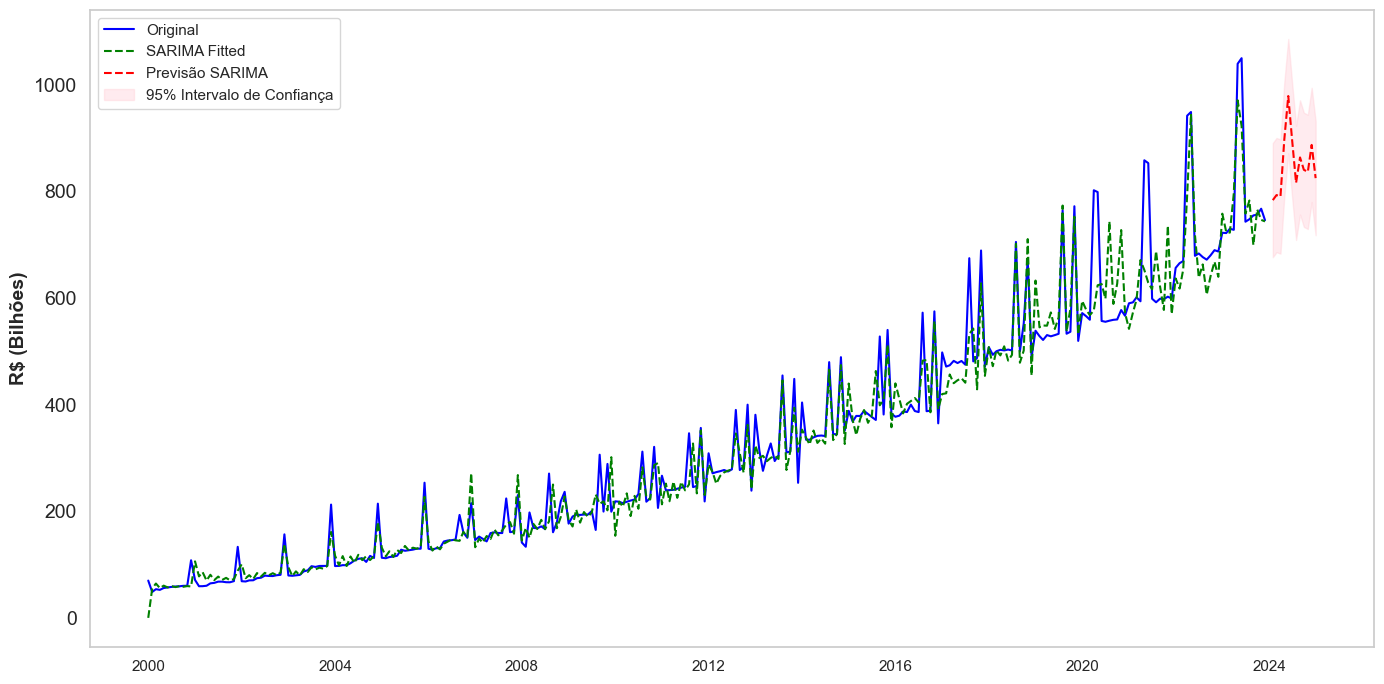

In [65]:
# Gráfico com série original, fitted e previsão
plt.figure(figsize=(14, 7))

# Série original e fitted (divididas por 100 para ficar em bilhões)
sns.lineplot(data=df_sarima, x=df_sarima.index, y=df_sarima['Valor'] / 100, label='Original', color='blue')
sns.lineplot(data=df_sarima, x=df_sarima.index, y=df_sarima['fitted'] / 100, label='SARIMA Fitted', color='green', linestyle='--')

# Previsão e intervalo de confiança
sns.lineplot(x=forecast_index, y=forecast_values / 100, label='Previsão SARIMA', color='red', linestyle='--')
plt.fill_between(forecast_index, lower_bound / 100, upper_bound / 100, color='pink', alpha=0.3, label='95% Intervalo de Confiança')

# Ajustes de formato
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('')
plt.yticks(fontsize=14)

plt.ylabel('R$ (Bilhões)', fontsize=14, fontweight='bold')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
# Criando a figura interativa
fig = go.Figure()

# Configurar o Plotly para exibir no VS Code primeiro
pio.renderers.default = "vscode"

# Linha da série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Linha da previsão SARIMA
fig.add_trace(go.Scatter(
    x=forecast_index,
    y=forecast_values,
    mode='lines',
    name='Previsão SARIMA',
    line=dict(color='red', dash='dash')
))

# Área do intervalo de confiança
fig.add_trace(go.Scatter(
    x=list(forecast_index) + list(forecast_index[::-1]),
    y=list(upper_bound) + list(lower_bound[::-1]),
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',  # Cor rosa com transparência
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Intervalo de Confiança'
))

# Configurações do layout
fig.update_layout(
    title='Previsão dos gastos com benefícios da previdência utilizando SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()


In [101]:
# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()